# Semantic Segmentation Model Training and Evaluation

In [ ]:
!pip install segmentation-models

## Import Packages

In [1]:
from tensorflow.keras.utils import Sequence
from tensorflow import keras
import tensorflow as tf
from keras.models import load_model

from skimage.io import imread
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import shutil

#tf.logging.set_verbosity(tf.logging.ERROR)
import tensorboard
#%load_ext autoreload
#%autoreload 2
%matplotlib inline

import albumentations as albu
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)
 
from albumentations import Resize

import segmentation_models as sm
from segmentation_models import Unet
#from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score
from segmentation_models.metrics import IOUScore

Segmentation Models: using `keras` framework.


## Setup Environment

In [2]:
# mount drive to access the project
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
project_folder = "/content/drive/My Drive/w210_project"
%cd $project_folder

/content/drive/My Drive/w210_project


In [4]:
root_folder = "/content/drive/My Drive/w210_project/dataset/segmentation/"
data_folder = "/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel/"
models_folder = "/content/drive/My Drive/w210_project/models/segmentation/"

In [5]:
MODEL_NAME = "unet_solar_segmentation_model_org_val_test_combined.h5"
BASELINE_MODEL_NAME = "baseline_unet_solar_segmentation.h5"
IMG_SIZE = 512
BATCH_SIZE = 3
BACKBONE = "efficientnetb7"
LOG_DIR = project_folder + '/segmentation_logs/tensorboard_b7_val_test/'
BASELINE_LOG_DIR = project_folder + '/segmentation_logs/baseline_tensorboard/'

BEST_MODEL = models_folder+'/best_model/unet_solar_segmentation_model.h5'
CURRENT_MODEL = models_folder + MODEL_NAME
BASELINE_MODEL = models_folder + BASELINE_MODEL_NAME

## Copy over images and masks

In [ ]:
# copy images masks from the data_folder+from_folder to the data_folder/images/ and data_folder/masks/
def copy_downloaded_images_masks(from_folder):
  images_from_path = data_folder+from_folder+"/images/"
  masks_from_path = data_folder+from_folder+"/masks/"

  images_to_path = data_folder+"/images/"
  masks_to_path = data_folder+"/masks/"

  print(images_to_path)
  print(masks_to_path)

  if not os.path.exists(images_to_path):
      os.makedirs(images_to_path)

  if not os.path.exists(masks_to_path):
      os.makedirs(masks_to_path)

  images_names = os.listdir(images_from_path)
  images_names = [images_from_path+'/'+ name for name in images_names]
  print(images_names[0])

  masks_names = os.listdir(masks_from_path)
  masks_names = [masks_from_path+'/'+ name for name in masks_names]
  print(masks_names[0])

  # copy over images
  for name in images_names:
    shutil.copy(name, images_to_path)

  for name in masks_names:
    shutil.copy(name, masks_to_path)


#copy_downloaded_images_masks("zoom21_600/")
#copy_downloaded_images_masks("zoom20_600")
#copy_downloaded_images_masks("zoom21_416/")
#copy_downloaded_images_masks("zoom21_600_bigcities/")
#copy_downloaded_images_masks("zoom20_600_bigcities/")

/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel//images/
/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel//masks/
/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel/zoom21_600_bigcities//images//ckpv96kk900033h67otr7n5ne.png
/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel/zoom21_600_bigcities//masks//ckpv96kk900033h67otr7n5ne.png
/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel//images/
/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel//masks/
/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel/zoom20_600_bigcities//images//ckpvosp9700033a690a2o38d3.png
/content/drive/My Drive/w210_project/dataset/segmentation/solar_panel/zoom20_600_bigcities//masks//ckpvosp9700033a690a2o38d3.png


In [ ]:
# list the number of images in all folders
folder = data_folder+"images/"
!ls '$folder' | wc -l

folder = data_folder+"masks/"
!ls '$folder' | wc -l

folder = data_folder+"zoom21_416/images/"
!ls '$folder' | wc -l
folder = data_folder+"zoom21_416/masks/"
!ls '$folder' | wc -l

folder = data_folder+"zoom21_600/images/"
!ls '$folder' | wc -l
folder = data_folder+"zoom21_600/masks/"
!ls '$folder' | wc -l

folder = data_folder+"zoom20_600/images/"
!ls '$folder' | wc -l
folder = data_folder+"zoom20_600/masks/"
!ls '$folder' | wc -l

folder = data_folder+"zoom21_600_bigcities/images/"
!ls '$folder' | wc -l
folder = data_folder+"zoom21_600_bigcities/masks/"
!ls '$folder' | wc -l

folder = data_folder+"zoom20_600_bigcities/images/"
!ls '$folder' | wc -l
folder = data_folder+"zoom20_600_bigcities/masks/"
!ls '$folder' | wc -l

646
646
159
158
177
177
178
178
90
90
90
90


In [ ]:
# split data into train, val and test folder
def create_train_val_test_folders(): 
    root_dir = root_folder # root path
    images_folder = data_folder + "images/"
    masks_folder = data_folder + "masks/"
 
    folders = ['images', 'masks']

    val_ratio = 0.15
    test_ratio = 0.05

    # get all file names under 'images' folder
    all_file_names = os.listdir(images_folder)
    np.random.shuffle(all_file_names)
    train_names, val_names, test_names = np.split(np.array(all_file_names),
                                                              [int(len(all_file_names)* (1 - (val_ratio + test_ratio))), 
                                                              int(len(all_file_names)* (1 - test_ratio))])

    train_images_names = [images_folder+'/'+ name for name in train_names.tolist()]
    val_images_names = [images_folder+'/' + name for name in val_names.tolist()]
    test_images_names = [images_folder+'/' + name for name in test_names.tolist()]

    train_masks_names = [masks_folder+'/'+ name for name in train_names.tolist()]
    val_masks_names = [masks_folder+'/' + name for name in val_names.tolist()]
    test_masks_names = [masks_folder+'/' + name for name in test_names.tolist()]

    print('Total images: ', len(all_file_names))
    print('Training: ', len(train_images_names))
    print('Validation: ', len(val_images_names))
    print('Testing: ', len(test_images_names))


    # create folders
    os.makedirs(root_dir +'train/')
    os.makedirs(root_dir +'val/')
    os.makedirs(root_dir +'test/')

    for folder in folders:
      os.makedirs(root_dir +'train/'+folder)
      os.makedirs(root_dir +'val/'+folder)
      os.makedirs(root_dir +'test/'+folder)

    # copy over images
    for name in train_images_names:
      shutil.copy(name, root_dir +'train/images/')

    for name in val_images_names:
      shutil.copy(name, root_dir +'val/images/')

    for name in test_images_names:
      shutil.copy(name, root_dir +'test/images/')

    # Copy over masks
    for name in train_masks_names:
      shutil.copy(name, root_dir +'train/masks/')

    for name in val_masks_names:
      shutil.copy(name, root_dir +'val/masks/')

    for name in test_masks_names:
      shutil.copy(name, root_dir +'test/masks/')

#create_train_val_test_folders()

Total images:  646
Training:  516
Validation:  97
Testing:  33


In [ ]:
# split data into train, val folder
def create_train_validation_folders(): 
    root_dir = root_folder # root path
    images_folder = data_folder + "images/"
    masks_folder = data_folder + "masks/"
 
    folders = ['images', 'masks']

    val_ratio = 0.20

    # get all file names under 'images' folder
    all_file_names = os.listdir(images_folder)
    np.random.shuffle(all_file_names)
    train_names, val_names = np.split(np.array(all_file_names),[int(len(all_file_names)* (1 - val_ratio))])

    train_images_names = [images_folder+'/'+ name for name in train_names.tolist()]
    val_images_names = [images_folder+'/' + name for name in val_names.tolist()]

    train_masks_names = [masks_folder+'/'+ name for name in train_names.tolist()]
    val_masks_names = [masks_folder+'/' + name for name in val_names.tolist()]

    print('Total images: ', len(all_file_names))
    print('Training: ', len(train_images_names))
    print('Validation: ', len(val_images_names))

    # create folders
    os.makedirs(root_dir +'train_new/')
    os.makedirs(root_dir +'val_new/')

    for folder in folders:
      os.makedirs(root_dir +'train_new/'+folder)
      os.makedirs(root_dir +'val_new/'+folder)

    # copy over images
    for name in train_images_names:
      shutil.copy(name, root_dir +'train_new/images/')

    for name in val_images_names:
      shutil.copy(name, root_dir +'val_new/images/')

    # Copy over masks
    for name in train_masks_names:
      shutil.copy(name, root_dir +'train_new/masks/')

    for name in val_masks_names:
      shutil.copy(name, root_dir +'val_new/masks/')

#create_train_validation_folders()

Total images:  646
Training:  516
Validation:  130


In [10]:

# split training data into portions
def split_training_images(all_file_names, split): 
    root_dir = root_folder # root path
    train_src_folder = root_dir + 'train/'

    train_split_folder = root_dir + f'train_{split}/'
    print(train_split_folder)

    images_folder = train_src_folder + "images/"
    masks_folder = train_src_folder + "masks/"
 
    folders = ['images', 'masks']

    train_split_names, remaining_names = np.split(np.array(all_file_names),[int(len(all_file_names)* split)])

    train_images_names = [images_folder+'/'+ name for name in train_split_names.tolist()]
    train_masks_names = [masks_folder+'/'+ name for name in train_split_names.tolist()]

    print('Total training images: ', len(all_file_names))
    print('Training split: ', split)
    print('Training split images: ', len(train_images_names))

    # create to folder
    os.makedirs(train_split_folder)

    for folder in folders:
      os.makedirs(train_split_folder+folder)

    # copy over images
    for name in train_images_names:
      shutil.copy(name, train_split_folder+'images/')

    # Copy over masks
    for name in train_masks_names:
      shutil.copy(name, train_split_folder+'masks/')

# get all file names under 'train_new' folder
train_images_folder = root_folder + 'train/images/'
all_file_names = os.listdir(train_images_folder)
np.random.shuffle(all_file_names)

for i in range(1, 10):
  split = i/10
  #split_training_images(all_file_names, split)

/content/drive/My Drive/w210_project/dataset/segmentation/train_0.1/
Total training images:  516
Training split:  0.1
Training split images:  51
/content/drive/My Drive/w210_project/dataset/segmentation/train_0.2/
Total training images:  516
Training split:  0.2
Training split images:  103
/content/drive/My Drive/w210_project/dataset/segmentation/train_0.3/
Total training images:  516
Training split:  0.3
Training split images:  154
/content/drive/My Drive/w210_project/dataset/segmentation/train_0.4/
Total training images:  516
Training split:  0.4
Training split images:  206
/content/drive/My Drive/w210_project/dataset/segmentation/train_0.5/
Total training images:  516
Training split:  0.5
Training split images:  258
/content/drive/My Drive/w210_project/dataset/segmentation/train_0.6/
Total training images:  516
Training split:  0.6
Training split images:  309
/content/drive/My Drive/w210_project/dataset/segmentation/train_0.7/
Total training images:  516
Training split:  0.7
Trainin

## Data Generator Class

In [6]:
class DataGeneratorFolder(keras.utils.Sequence):
    def __init__(self, root_dir=r'./dataset/segmentation/solar_panel/', image_folder='images/', mask_folder='masks/', 
                 batch_size=BATCH_SIZE, image_size=IMG_SIZE, nb_y_features=1, 
                 augmentation=None, preprocessing= None,
                 suffle=True):
        self.images_folder = os.path.join(root_dir, image_folder)
        self.masks_folder = os.path.join(root_dir, mask_folder)
        self.image_filenames = os.listdir(os.path.join(root_dir, image_folder))        
        self.mask_names = os.listdir(os.path.join(root_dir, mask_folder))
        self.batch_size = batch_size
        self.currentIndex = 0
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.image_size = image_size
        self.nb_y_features = nb_y_features
        self.indexes = None
        self.suffle = suffle

        #print(self.image_filenames)
        
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.suffle==True:
            self.image_filenames, self.mask_names = shuffle(self.image_filenames, self.mask_names)
        
    def read_image_mask(self, image_name, mask_name):
        return cv2.imread(os.path.join(self.images_folder, image_name), cv2.IMREAD_COLOR)/255, (cv2.imread(os.path.join(self.masks_folder, image_name), cv2.IMREAD_GRAYSCALE) > 0).astype(np.float32)

    def __getitem__(self, index):
        """
        Generate one batch of data
        
        """
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))
        
        indexes = self.image_filenames[data_index_min:data_index_max]

        this_batch_size = len(indexes) # The last batch can be smaller than the others
        
        # Defining dataset
        X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
        y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.float32)

        for i, sample_index in enumerate(indexes):

            X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i], 
                                                    self.mask_names[index * self.batch_size + i])
            
            # resize the images first
            resized = Resize(height=self.image_size, width=self.image_size)(image = X_sample, mask = y_sample)
            X_sample = resized['image']
            y_sample = resized['mask']
                        
            # apply preprocessing
            if self.preprocessing:
              sample = self.preprocessing(image=X_sample, mask=y_sample)
              X_sample, y_sample = sample['image'], sample['mask']

            # if augmentation is defined, apply augmentation to X_sample, y_sample
            if self.augmentation is not None:                  
                # Augmentation code
                augmented = self.augmentation(self.image_size)(image=X_sample, mask=y_sample)
                image_augm = augmented['image'].reshape(self.image_size, self.image_size, 3)
                mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                X[i, ...] = np.clip(image_augm, a_min = 0, a_max=1)
                y[i, ...] = mask_augm
            
            # if augmentation is not defined 
            elif self.augmentation is None:                
                # just resize the images
                augmented = Resize(height=self.image_size, width=self.image_size)(image = X_sample, mask = y_sample)
                X_sample = augmented['image'].reshape(self.image_size, self.image_size, 3)
                y_sample = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                
                X[i, ...] = X_sample
                y[i, ...] = y_sample
                
        return X, y


## Augmentation and Train, Val, Test Generators

In [7]:
# define augmentation function
def aug_with_crop(image_size = IMG_SIZE, crop_prob = 1):
    return Compose([
        #PadIfNeeded(min_height=image_size, min_width=image_size, always_apply=True, border_mode=0),
        RandomCrop(width = image_size, height = image_size, p=crop_prob),
        HorizontalFlip(p=0.5),
        #VerticalFlip(p=0.5),
        #RandomRotate90(p=0.5),
        Transpose(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=0.5),
        RandomGamma(p=0.25),
        IAAEmboss(p=0.25),
        Blur(p=0.01, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

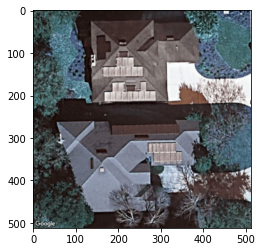

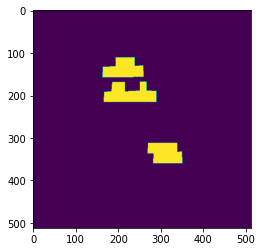

In [ ]:
# check one example of data generator
example_data_generator = DataGeneratorFolder(root_dir = root_folder+'train/',
                                     image_folder = 'images/', 
                                     mask_folder = 'masks/',
                                     batch_size = BATCH_SIZE,
                                     nb_y_features = 1, 
                                     augmentation = None)
Xtest, ytest = example_data_generator.__getitem__(5)
plt.imshow(Xtest[0])     
plt.show()
plt.imshow(ytest[0, :,:,0])
plt.show()

In [ ]:
##################### remove this later #########################
#preprocess_input = sm.get_preprocessing(BACKBONE)

train_generator = DataGeneratorFolder(root_dir = root_folder+'train/', 
                                      image_folder = 'images/', 
                                      mask_folder = 'masks/', 
                                      augmentation = aug_with_crop,
                                      preprocessing = None,
                                      batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE)

val_generator = DataGeneratorFolder(root_dir = root_folder+'val/', 
                                      image_folder = 'images/', 
                                      mask_folder = 'masks/', 
                                      augmentation = None,
                                      preprocessing = None,
                                      batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE)

test_generator = DataGeneratorFolder(root_dir = root_folder+'test/', 
                                     image_folder = 'images/', 
                                     mask_folder = 'masks/', 
                                     augmentation = None,
                                     preprocessing = None,
                                     batch_size=1,
                                     image_size=IMG_SIZE)

In [8]:
# Set up train and validation data generators

train_generator = DataGeneratorFolder(root_dir = root_folder+'train/', 
                                      image_folder = 'images/', 
                                      mask_folder = 'masks/', 
                                      augmentation = aug_with_crop,
                                      preprocessing = None,
                                      batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE)

val_generator = DataGeneratorFolder(root_dir = root_folder+'val_test/', 
                                      image_folder = 'images/', 
                                      mask_folder = 'masks/', 
                                      augmentation = None,
                                      preprocessing = None,
                                      batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE)

eval_generator = DataGeneratorFolder(root_dir = root_folder+'val_test/', 
                                     image_folder = 'images/', 
                                     mask_folder = 'masks/', 
                                     augmentation = None,
                                     preprocessing = None,
                                     batch_size=1,
                                     image_size=IMG_SIZE)

## Functions


In [9]:
#### TODO: Try with bce_dice_loss loss ########

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [10]:
# set up callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

def setup_callbacks(model_name=MODEL_NAME, log_dir=LOG_DIR):
  # reduces learning rate on plateau
  lr_reducer = ReduceLROnPlateau(factor=0.1,
                                cooldown= 10,
                                patience=10,
                                verbose =1,
                                min_lr=0.1e-5)
  mode_autosave = ModelCheckpoint(models_folder+model_name, monitor='val_iou_score', 
                                    mode = 'max', save_best_only=True, verbose=1, save_freq='epoch')

  # stop learining as metric on validatopn stop increasing
  early_stopping = EarlyStopping(patience=20, verbose=1, mode = 'auto') 

  # tensorboard for monitoring logs
  tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0,
                            write_graph=True, write_images=False)

  callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]
  return callbacks

# plot training history
def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()

# train baseline model
def train_unet_baseline_model():
  preprocess_input = sm.get_preprocessing('mobilenetv2')

  LR = 0.0001
  sm.set_framework('tf.keras')
  model = Unet(backbone_name = 'mobilenetv2', encoder_weights='imagenet', encoder_freeze = False)

  # define optimizer, loss and metrics
  optim = keras.optimizers.Adam(LR)
  bce_jaccard_loss = sm.losses.bce_jaccard_loss
  binary_crossentropy = sm.losses.binary_crossentropy
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  # compile keras model with defined optimizer, loss, and metrics
  model.compile(optim, bce_jaccard_loss, metrics)

  # stop learining as metric on validatopn stop increasing
  early_stopping = EarlyStopping(patience=20, verbose=1, mode = 'auto') 
  mode_autosave = ModelCheckpoint(models_folder+BASELINE_MODEL_NAME, monitor='val_iou_score', 
                                    mode ='max', save_best_only=True, verbose=1, save_freq='epoch')
  callbacks = [mode_autosave, early_stopping]

  model_history = model.fit(train_generator, shuffle =True,
                    epochs=100, workers=4, use_multiprocessing=True,
                    validation_data = val_generator, 
                    verbose = 1, callbacks=callbacks)
  
  return model, model_history
  
def evaluate_model_from_path(model_path_name, message, eval_generator=eval_generator):
  model = load_model(model_path_name,
                    custom_objects={'iou_score': IOUScore(threshold=0.5), 
                                    'f1-score': sm.metrics.FScore(threshold=0.5),
                                    'binary_crossentropy_plus_jaccard_loss': sm.losses.bce_jaccard_loss})

  # Evaluation of the model
  preds = []
  y_val = []
  scores = []
  for i in (range(0,eval_generator.__len__())):
      Xtest, y_test  = eval_generator.__getitem__(i)
      preds.append(model.predict(Xtest).reshape(IMG_SIZE, IMG_SIZE))
      y_val.append(y_test)
      score = model.evaluate(Xtest, y_test)
      scores.append(score)

  preds = np.stack(preds, axis=0)
  y_val = np.stack(y_val, axis=0)

  mean_iou = iou_metric_batch(y_val, preds)
  print("{} Model Mean IOU with iou_metric_batch: {}".format(message, mean_iou))

  #print(scores)
  scores_array = np.array(scores)
  print("{} Model Mean Loss: {:.5}".format(message, np.mean(scores_array[:,0])))
  mean_iou = np.mean(scores_array[:, 1])
  print("{} Model Mean IOU: {:.5}".format(message, mean_iou))
  mean_f1 = np.mean(scores_array[:, 2])
  print("{} Model Mean F1-Score: {:.5}".format(message, mean_f1))

def model_mean_iou(model_path_name, eval_generator=eval_generator):
  model = load_model(model_path_name,
                    custom_objects={'iou_score': IOUScore(threshold=0.5), 
                                    'f1-score': sm.metrics.FScore(threshold=0.5),
                                    'binary_crossentropy_plus_jaccard_loss': sm.losses.bce_jaccard_loss})

  # Evaluation of the model
  preds = []
  y_val = []
  scores = []
  for i in (range(0,eval_generator.__len__())):
      Xtest, y_test  = eval_generator.__getitem__(i)
      preds.append(model.predict(Xtest).reshape(IMG_SIZE, IMG_SIZE))
      y_val.append(y_test)
      score = model.evaluate(Xtest, y_test)
      scores.append(score)

  preds = np.stack(preds, axis=0)
  y_val = np.stack(y_val, axis=0)

  mean_iou = iou_metric_batch(y_val, preds)
  return mean_iou
  
def build_solar_segment_model():
  LR = 0.0001
  sm.set_framework('tf.keras')
  model = Unet(backbone_name = BACKBONE, encoder_weights='imagenet', encoder_freeze = False)

  # define optimizer, loss and metrics
  optim = keras.optimizers.Adam(LR)
  bce_jaccard_loss = sm.losses.bce_jaccard_loss
  binary_crossentropy = sm.losses.binary_crossentropy
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  # compile keras model with defined optimizer, loss, and metrics
  model.compile(optim, bce_jaccard_loss, metrics)
  return model

def train_solar_segment_model(model, callbacks, train_generator=train_generator, val_generator=val_generator):
  history = model.fit(train_generator, shuffle =True,
                  epochs=100, workers=4, use_multiprocessing=True,
                  validation_data = val_generator, 
                  verbose = 1, callbacks=callbacks)
  return model, history

# functions for evaluating iou metric
def iou_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    return iou

def plot_mask_groundtruth_image(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(mask, cmap="Greys")
    axs[1].imshow(groud_truth, cmap="Blues")
    axs[2].imshow(img)
    plt.show()
    
def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)



## Baseline Model

In [ ]:
# train baseline model
baseline_model, baseline_history = train_unet_baseline_model()

/usr/local/lib/python3.7/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/100
172/172 [==============================] - 58s 195ms/step - loss: 1.1341 - iou_score: 0.3825 - f1-score: 0.5181 - val_loss: 1.2482 - val_iou_score: 0.3466 - val_f1-score: 0.4967

Epoch 00001: val_iou_score improved from -inf to 0.34661, saving model to /content/drive/My Drive/w210_project/models/segmentation/baseline_unet_solar_segmentation.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
172/172 [==============================] - 33s 189ms/step - loss: 0.8251 - iou_score: 0.5642 - f1-score: 0.7032 - val_loss: 0.7960 - val_iou_score: 0.4945 - val_f1-score: 0.6446

Epoch 00002: val_iou_score improved from 0.34661 to 0.49445, saving model to /content/drive/My Drive/w210_project/models/segmentation/baseline_unet_solar_segmentation.h5
Epoch 3/100
172/172 [==============================] - 33s 186ms/step - loss: 0.6323 - iou_score: 0.6334 - f1-score: 0.7638 - val_loss: 0.6167 - val_iou_score: 0.5686 - val_f1-score: 0.7119

Epoch 00003: val_iou_score improved from 0.49445 to 0.56864, saving model to /content/drive/My Drive/w210_project/models/segmentation/baseline_unet_solar_segmentation.h5
Epoch 4/100
172/172 [==============================] - 33s 188ms/step - loss: 0.4899 - iou_score: 0.6903 - f1-score: 0.8063 - val_loss: 0.5409 - val_iou_score: 0.6090 - val_f1-score: 0.7435

Epoch 00004: val_iou_score improved from 0.56864 to 0.60899, saving model to /content/d

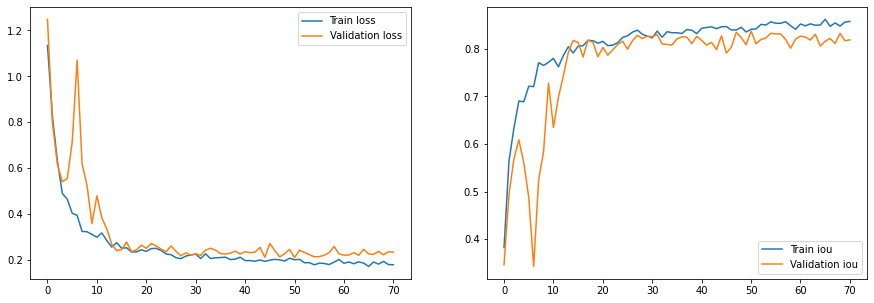

In [ ]:
plot_training_history(baseline_history)

In [ ]:
evaluate_model_from_path(BASELINE_MODEL, "Baseline", eval_generator=eval_generator)

1/1 [==============================] - 0s 33ms/step - loss: 0.2029 - iou_score: 0.8334 - f1-score: 0.9091
Baseline Model Mean IOU with iou_metric_batch: 0.8066951485388005
Baseline Model Mean Loss: 0.24292
Baseline Model Mean IOU: 0.8067
Baseline Model Mean F1-Score: 0.88447


In [ ]:
baseline_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
______________________________________________________________________________________________

## Train Semantic Segmentation Model

In [14]:
# train solar panel segmentation model
callbacks = setup_callbacks()
model = build_solar_segment_model()
model, history = train_solar_segment_model(model, callbacks)

258441216/258434480 [==============================] - 5s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
172/172 [==============================] - 258s 1s/step - loss: 1.2759 - iou_score: 0.3459 - f1-score: 0.4721 - val_loss: 1.1207 - val_iou_score: 0.5301 - val_f1-score: 0.6822

Epoch 00001: val_iou_score improved from -inf to 0.53010, saving model to /content/drive/My Drive/w210_project/models/segmentation/unet_solar_segmentation_model_org_val_test_combined.h5
Epoch 2/100
172/172 [==============================] - 90s 518ms/step - loss: 0.9296 - iou_score: 0.5989 - f1-score: 0.7317 - val_loss: 0.7960 - val_iou_score: 0.7521 - val_f1-score: 0.8532

Epoch 00002: val_iou_score improved from 0.53010 to 0.75213, saving model to /content/drive/My Drive/w210_project/models/segmentation/unet_solar_segmentation_model_org_val_test_combined.h5
Epoch 3/100
172/172 [==============================] - 90s 520ms/step - loss: 0.7334 - iou_score: 0.6586 - f1-score: 0.7801 - val_loss: 0.6046 - val_iou_score: 0.7779 - val_f1-score: 0.8724

Epoch 00003: val_iou_score improved from 0.75213 to 0.

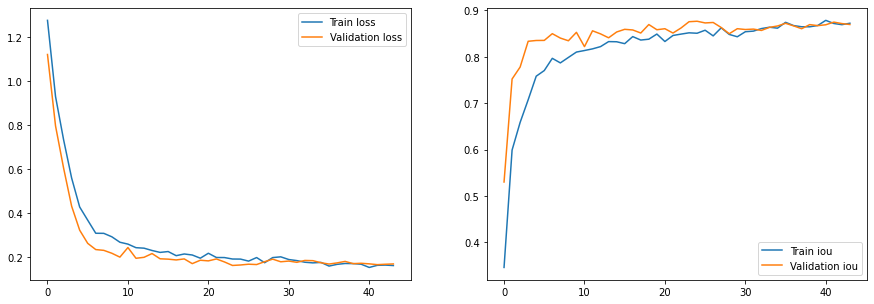

In [15]:
plot_training_history(history)

In [ ]:
# plot tesorboard logs
%load_ext tensorboard
%tensorboard --logdir logs

In [17]:
# evaluate the current trained model
evaluate_model_from_path(CURRENT_MODEL, "Current", eval_generator=eval_generator)

1/1 [==============================] - 0s 61ms/step - loss: 0.1173 - iou_score: 0.9049 - f1-score: 0.9500
Current Model Mean IOU with iou_metric_batch: 0.8539349541967879
Current Model Mean Loss: 0.18774
Current Model Mean IOU: 0.85393
Current Model Mean F1-Score: 0.91677


## Evaluate Model

In [ ]:
scores = model.evaluate_generator(val_generator)
metrics=[iou_score]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

## Load Best Model and Evaluate

In [18]:
# evaluate baseline
#evaluate_model_from_path(BASELINE_MODEL, "Baseline", test_generator=val_generator)

# evaluate best model
evaluate_model_from_path(BEST_MODEL, "Best", eval_generator=eval_generator)

1/1 [==============================] - 0s 57ms/step - loss: 0.0952 - iou_score: 0.9189 - f1-score: 0.9578
Best Model Mean IOU with iou_metric_batch: 0.8609137813016553
Best Model Mean Loss: 0.17617
Best Model Mean IOU: 0.86091
Best Model Mean F1-Score: 0.92046


## Show Single Image Prediction

IOU [[0.94486949]]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(512, 512), dtype=int32)


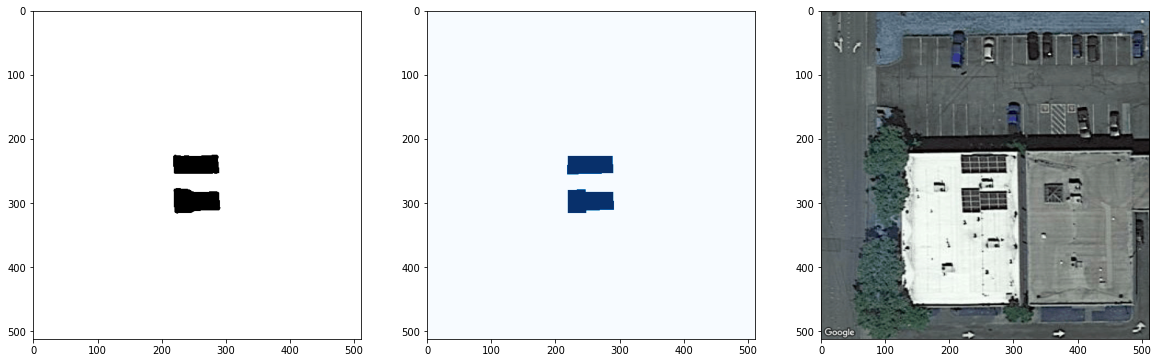

In [ ]:
def get_single_image_prediction():
  current_model = load_model(CURRENT_MODEL,
                   custom_objects={'iou_score': IOUScore(threshold=0.5), 
                                   'f1-score': sm.metrics.FScore(threshold=0.5),
                                   'binary_crossentropy_plus_jaccard_loss': sm.losses.bce_jaccard_loss})

  # get single image and its prediction 
  Xtest, y_test  = test_generator.__getitem__(2)
  predicted = current_model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(IMG_SIZE, IMG_SIZE)
  print('IOU', iou_metric(y_test[0].reshape(IMG_SIZE, IMG_SIZE), predicted))

  predicted = tf.where(predicted < 0.5, 0, 1)
  print(predicted)
  plot_mask_groundtruth_image(predicted, y_test.squeeze(0).squeeze(-1), Xtest.squeeze(0))

  return y_test, predicted
  
y_test, predicted = get_single_image_prediction() 

## Adjust threshold

In [ ]:
def get_best_threshold(ious, thresholds):
    """
    Returns threshold_best, iou_best
    """
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    return threshold_best, iou_best

preds = []
y_val = []
for i in (range(0,test_generator.__len__())):
    Xtest, y_test  = test_generator.__getitem__(i)
    preds.append(best_model.predict(Xtest).reshape(IMG_SIZE, IMG_SIZE))
    y_val.append(y_test)
preds = np.stack(preds, axis=0)
y_val = np.stack(y_val, axis=0)

thresholds = list(np.linspace(0.1, 0.9, 10))
ious = np.array([iou_metric_batch(y_val, np.int32(preds > threshold)) for threshold in (thresholds)])

best_threshold, best_iou = get_best_threshold(ious, thresholds)

## Test real examples

In [ ]:
from tensorflow import keras
from keras.models import load_model
import segmentation_models as sm
from segmentation_models.metrics import IOUScore
import matplotlib.pyplot as plt

In [ ]:
i = 0
test_filenames = glob.glob(root_folder+'./test_examples/*')
batch_size = len(test_filenames)
X = np.empty((batch_size, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

for image in test_filenames:
  test_image = cv2.imread(image, cv2.IMREAD_COLOR)/255
  resized = cv2.resize(test_image, (IMG_SIZE, IMG_SIZE))
  X_sample = resized.reshape(IMG_SIZE, IMG_SIZE, 3)
                
  X[i, ...] = X_sample
  i = i+1

predicted = (best_model.predict(X))
for i in range(0, len(predicted)):
    predicted[i] = tf.where(predicted[i] < 0.5, 0, 1)

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10,10))
for i in range(0, len(X)):
  axs[i][0].imshow(X[i])
  axs[i][1].imshow(predicted[i].reshape(IMG_SIZE, IMG_SIZE), cmap="Greys")


## Plot Dataset Size vs. IOU


In [11]:
size_iou = []
for i in range(9, 10):
  results_dict = {}
  split = i/10
  print(f'######### Iteration {i} #############')
  train_dataset_part = DataGeneratorFolder(root_dir = root_folder+f'train_{split}/', 
                                      image_folder = 'images/', 
                                      mask_folder = 'masks/', 
                                      augmentation = aug_with_crop,
                                      preprocessing = None,
                                      batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE)
  #train_dataset_part = train_dataset_part.cache().prefetch(buffer_size=AUTOTUNE)

  model_name = f'unet_solar_segmentation_split_{i}.h5'

  # train solar panel segmentation model
  callbacks = setup_callbacks(model_name=model_name, 
                            log_dir=f'/content/drive/My Drive/w210_project/segmentation_logs/split_{i}')

  model = build_solar_segment_model()
  model, history = train_solar_segment_model(model, callbacks, train_dataset_part)
  #plot_training_history(history)

  iou = model_mean_iou(models_folder+model_name, eval_generator)
  print(f'IOU: {iou}')
  results_dict = results_dict.update({'Dataset size':len(train_dataset_part), 'Model IOU':iou})
  size_iou.append(results_dict)

print(size_iou)


######### Iteration 9 #############


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
155/155 [==============================] - 154s 747ms/step - loss: 1.2673 - iou_score: 0.3786 - f1-score: 0.5049 - val_loss: 1.1638 - val_iou_score: 0.4693 - val_f1-score: 0.6242

Epoch 00001: val_iou_score improved from -inf to 0.46931, saving model to /content/drive/My Drive/w210_project/models/segmentation/unet_solar_segmentation_split_9.h5
Epoch 2/100
155/155 [==============================] - 83s 527ms/step - loss: 0.9626 - iou_score: 0.5966 - f1-score: 0.7296 - val_loss: 0.8302 - val_iou_score: 0.7092 - val_f1-score: 0.8246

Epoch 00002: val_iou_score improved from 0.46931 to 0.70919, saving model to /content/drive/My Drive/w210_project/models/segmentation/unet_solar_segmentation_split_9.h5
Epoch 3/100
155/155 [==============================] - 83s 528ms/step - loss: 0.7781 - iou_score: 0.6626 - f1-score: 0.7837 - val_loss: 0.6252 - val_iou_score: 0.7657 - val_f1-score: 0.8614

Epoch 00003: val_iou_score improved from 0.70919 to 0.76571, saving model to /content/drive

In [13]:
iou = model_mean_iou(models_folder+'unet_solar_segmentation_split_10', eval_generator)
print(iou)

0.8646017815869433


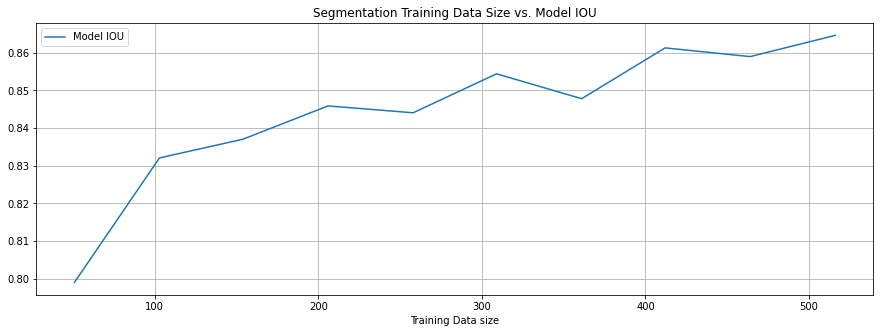

In [15]:
import pandas as pd

#df = pd.DataFrame([size_iou])
sizes = [51, 103, 154, 206, 258, 309, 361, 412, 464, 516]  
iou = [0.79902, 0.83207, 0.83703, 0.84587, 0.84405, 0.85439, 0.84779, 0.86127, 0.85896, 0.86460]
  
# Calling DataFrame constructor after zipping
df = pd.DataFrame(list(zip(sizes, iou)),
               columns =['Training Data size', 'Model IOU'])
df.plot(x='Training Data size', y='Model IOU', figsize=(15, 5), grid=True, title='Segmentation Training Data Size vs. Model IOU')

## Error Analysis

IOU [[0.65205092]]


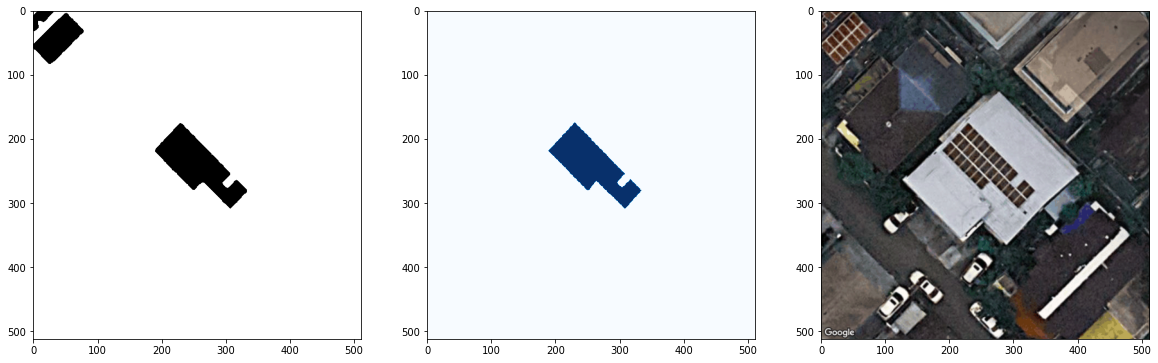

IOU [[0.48181245]]


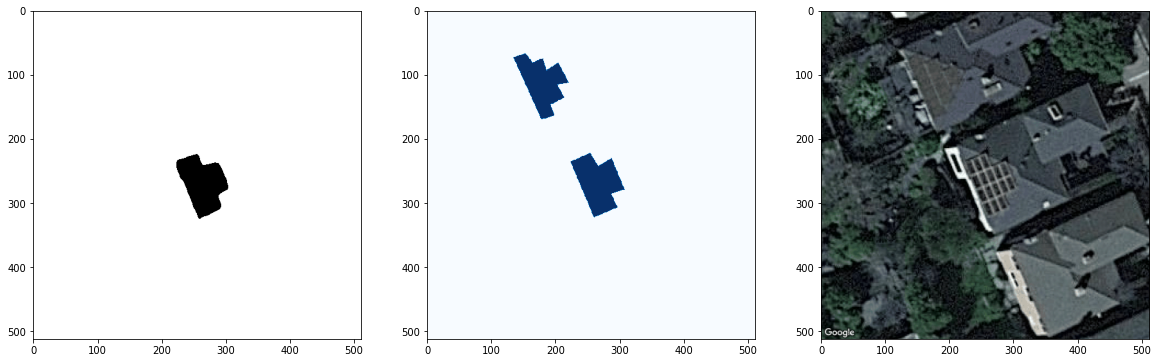

IOU [[0.50381232]]


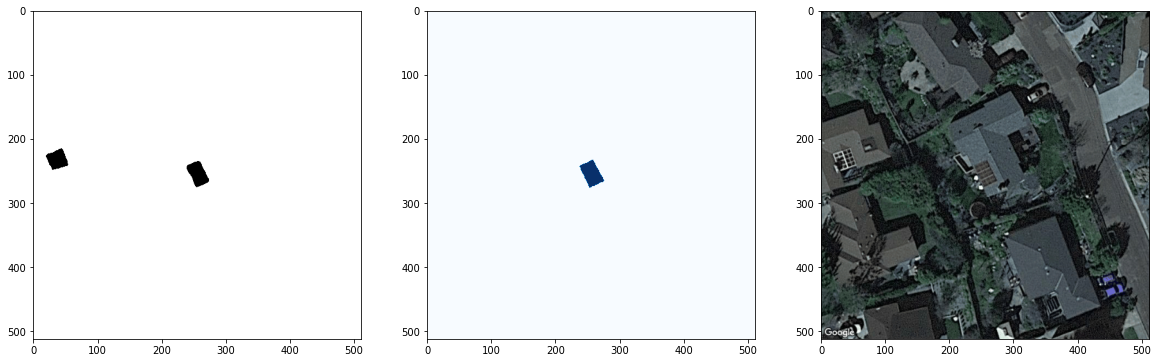

IOU [[0.65150233]]


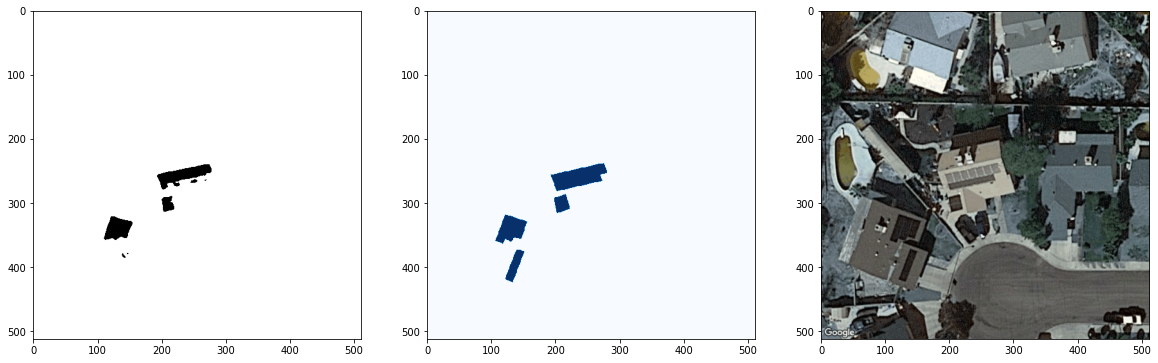

IOU [[0.51373839]]


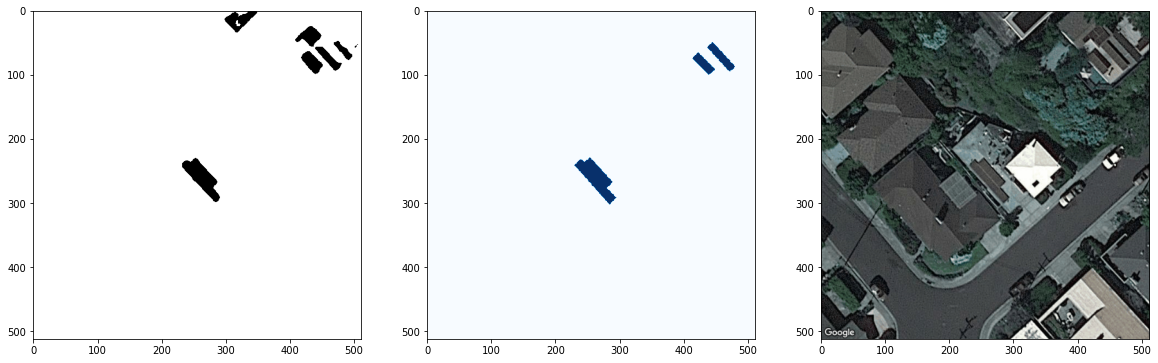

IOU [[0.48063426]]


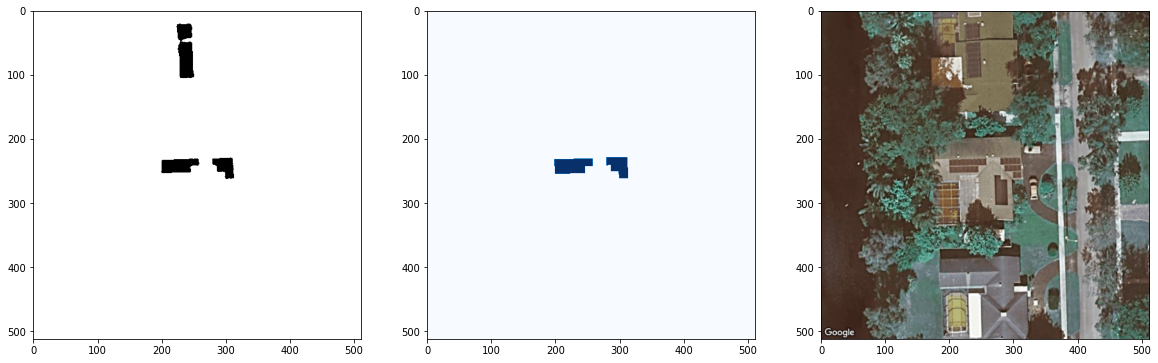

IOU [[0.6037037]]


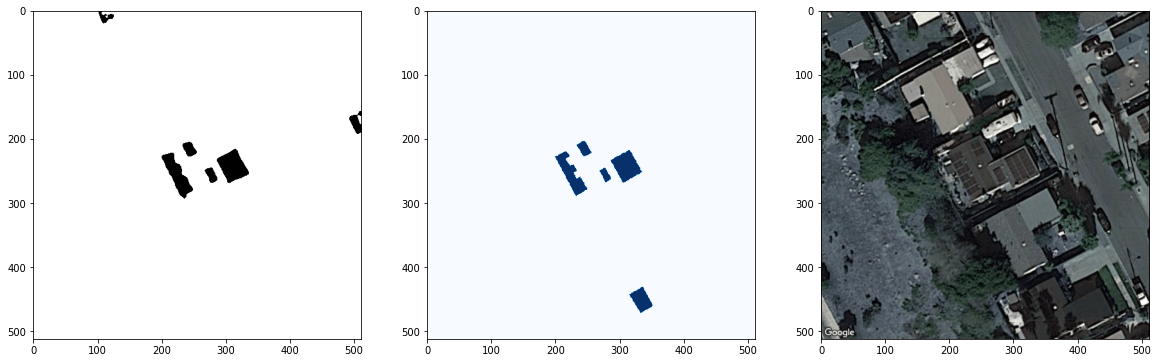

IOU [[0.56282775]]


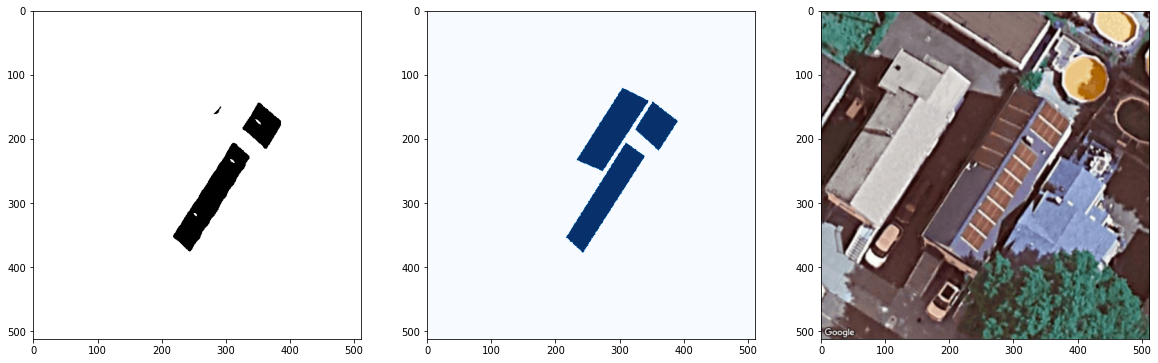

IOU [[0.55667702]]


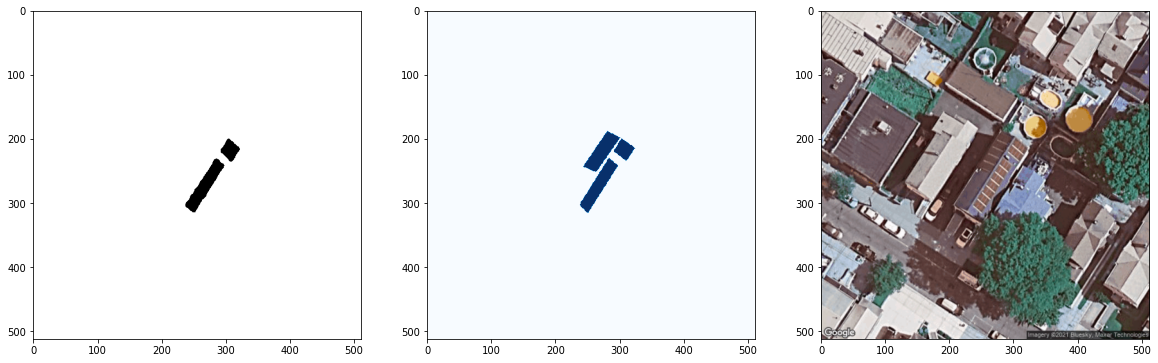

IOU [[0.37287447]]


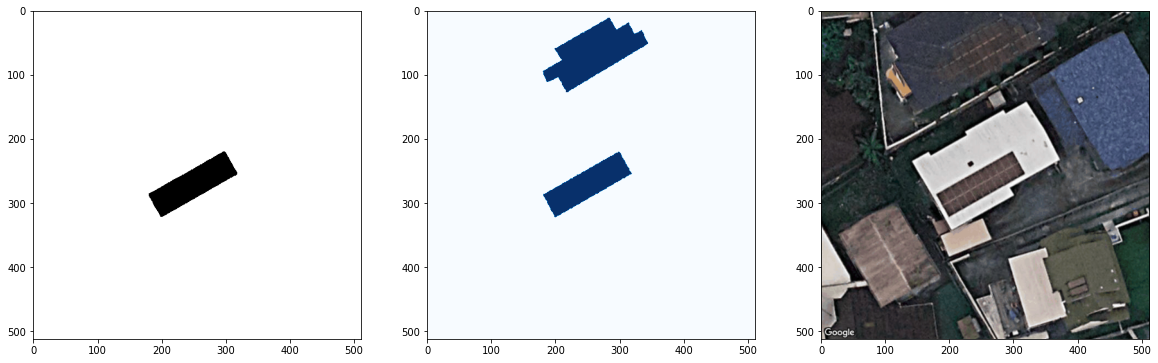

IOU [[0.69126837]]


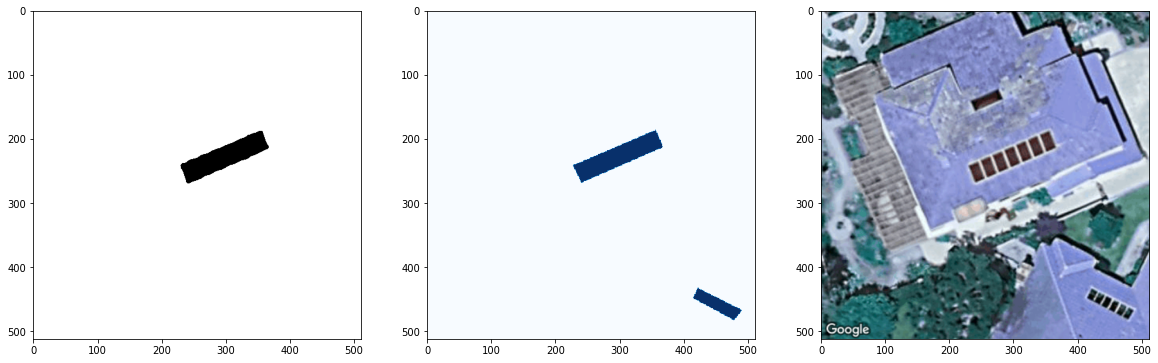

In [14]:
def show_low_iou_predictions(iou_threshold=0.7):
  model = load_model(BEST_MODEL,
                   custom_objects={'iou_score': IOUScore(threshold=0.5), 
                                   'f1-score': sm.metrics.FScore(threshold=0.5),
                                   'binary_crossentropy_plus_jaccard_loss': sm.losses.bce_jaccard_loss})

  # get predictions for images
  for i in (range(0, eval_generator.__len__())):
    Xtest, y_test  = eval_generator.__getitem__(i)
    predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(IMG_SIZE, IMG_SIZE)
    iou = iou_metric(y_test[0].reshape(IMG_SIZE, IMG_SIZE), predicted)
    #score = score = model.evaluate(Xtest, y_test)
    #print(score)
    #iou = score[1]
    if (iou < iou_threshold):
      print('IOU', iou)
      predicted = tf.where(predicted < 0.5, 0, 1)
      #print(predicted)
      plot_mask_groundtruth_image(predicted, y_test.squeeze(0).squeeze(-1), Xtest.squeeze(0))
 
show_low_iou_predictions()